# 计算空间自相关指数（莫兰指数）
## 获取阿姆斯特丹的郊区范围

文章是计算的教区的莫兰指数，为了证明在郊区，建筑年代呈现出较弱的空间自相关性，即预测准确度在空间上既不是完全随机的，也不是强烈聚集的。我暂时没找到阿姆斯特丹的郊区范围，我们通过计算粗略画了一个市中心范围来演示如何用pysal计算莫兰指数。

## 1.获取含建筑位置信息和真实年代的建筑数据
我们可以根据150m的网格来计算空间自相关 网格的建筑年代选择她所包含建筑的众数

In [105]:
import geopandas as gpd
import pandas as pd

gdb = r"../../5-ArcgisPro工程/建筑风格和年代深度学习.gdb" # 
lr_name = 'Amsterdam_buildings_Project'
gdf = gpd.read_file(filename=gdb, layer=lr_name)
gdf.head()

,rdf_seealso,identificatie,bouwjaar,status,gebruiksdoel,oppervlakte_min,oppervlakte_max,aantal_verblijfsobjecten,geom_Length,geom_Area,geometry
0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012061709,2007,Pand in gebruik,woonfunctie,331.0,331.0,1,60.067413,173.201627,"MULTIPOLYGON (((635512.808 5802343.021, 635518..."
1,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012061225,1923,Pand in gebruik,woonfunctie,84.0,84.0,1,28.671057,48.016138,"MULTIPOLYGON (((628083.847 5808893.547, 628087..."
2,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012061228,2004,Pand in gebruik,woonfunctie,93.0,128.0,2,38.826189,80.168377,"MULTIPOLYGON (((635718.103 5802400.059, 635709..."
3,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012062224,1916,Pand in gebruik,woonfunctie,50.0,80.0,4,36.203712,61.107085,"MULTIPOLYGON (((632084.702 5803319.551, 632084..."
4,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012063200,1965,Pand in gebruik,overige gebruiksfunctie,1.0,1.0,1,18.999679,19.500827,"MULTIPOLYGON (((628012.652 5798762.544, 628013..."


## 2.空间连接

In [107]:
# 读取渔网
gdf_fishnet = gpd.read_file(filename=gdb, layer='fishnet')

# 读取渔网标注点
gdf_fishnet_label = gpd.read_file(filename=gdb, layer='fishnet_label')

In [108]:
len(gdf_fishnet), len(gdf_fishnet_label)

(12150, 12150)

In [109]:
# 给渔网和标注点添加id列
gdf_fishnet['id_left'] = gdf_fishnet.index
gdf_fishnet_label['id_left'] = gdf_fishnet_label.index

In [110]:
# 查看geopandas的版本
gpd.__version__

'0.12.2'

### 空间连接的方法：一种是使用geopandas.GeoDataFrame.sjoin_nearest 空间连接，一种是使用geopandas.GeoDataFrame.sjoin 空间连接

- [官方帮助文档](https://geopandas.org/en/latest/docs/user_guide/mergingdata.html#spatial-joins)

In [111]:
# 我们已经有方格网了，直接使用geopandas.GeoDataFrame.sjoin 空间连接, 保留左边的数据，即渔网的数据，然后根据右侧的数据进行计算
gdf_fishnet = gpd.sjoin(gdf_fishnet, gdf, how='left', predicate='intersects') # op参数在将来的版本中将被弃用，并建议您使用predicate参数代替。
len(gdf_fishnet)

196959

In [112]:
gdf_fishnet.head()

,Shape_Length,Shape_Area,geometry,id_left,index_right,rdf_seealso,identificatie,bouwjaar,status,gebruiksdoel,oppervlakte_min,oppervlakte_max,aantal_verblijfsobjecten,geom_Length,geom_Area
0,600.0,22500.0,"MULTIPOLYGON (((617784.839 5798425.740, 617784...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,600.0,22500.0,"MULTIPOLYGON (((617934.839 5798425.740, 617934...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,600.0,22500.0,"MULTIPOLYGON (((618084.839 5798425.740, 618084...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,600.0,22500.0,"MULTIPOLYGON (((618234.839 5798425.740, 618234...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,600.0,22500.0,"MULTIPOLYGON (((618384.839 5798425.740, 618384...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# 扔掉空网格数据
gdf_fishnet = gdf_fishnet.dropna(subset=['bouwjaar'])
gdf_fishnet.head()

,Shape_Length,Shape_Area,geometry,id_left,index_right,rdf_seealso,identificatie,bouwjaar,status,gebruiksdoel,oppervlakte_min,oppervlakte_max,aantal_verblijfsobjecten,geom_Length,geom_Area
58,600.0,22500.0,"MULTIPOLYGON (((626484.839 5798425.740, 626484...",58,78305.0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012219206,1999.0,Pand in gebruik,overige gebruiksfunctie,33.0,33.0,1.0,25.768368,39.462713
58,600.0,22500.0,"MULTIPOLYGON (((626484.839 5798425.740, 626484...",58,77154.0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012098206,2000.0,Pand in gebruik,winkelfunctie,702.0,702.0,1.0,87.990630,420.873348
58,600.0,22500.0,"MULTIPOLYGON (((626484.839 5798425.740, 626484...",58,76449.0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012062550,1940.0,Pand in gebruik,"winkelfunctie,woonfunctie",58.0,104.0,7.0,59.394625,167.876756
58,600.0,22500.0,"MULTIPOLYGON (((626484.839 5798425.740, 626484...",58,78029.0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012142486,1938.0,Pand in gebruik,woonfunctie,160.0,160.0,1.0,33.945079,66.521755
58,600.0,22500.0,"MULTIPOLYGON (((626484.839 5798425.740, 626484...",58,77008.0,http://bag.basisregistraties.overheid.nl/bag/i...,0363100012090243,2002.0,Pand in gebruik,woonfunctie,102.0,102.0,1.0,32.200195,58.336294


In [114]:
import pandas as pd

# 定义一个函数来获取众数
def mode_function(x):
    # 计算众数
    modes = x.mode()
    
    # 如果有多个众数，我们可以选择返回第一个
    if len(modes) > 0:
        return modes.iloc[0]
    else:
        return None  # 或者您可以选择一个默认值

In [115]:
# 根据网格进行分类统计 使用groupby或者geopandas的dissolve，我们使用dissolve
mode_150m = gdf_fishnet.dissolve(by='id_left', aggfunc={"bouwjaar": mode_function})

In [116]:
mode_150m

,geometry,bouwjaar
id_left,,
58,"POLYGON ((626484.839 5798425.740, 626484.839 5...",1939.0
59,"POLYGON ((626784.839 5798425.740, 626634.839 5...",2010.0
60,"POLYGON ((626934.839 5798575.740, 626934.839 5...",2006.0
61,"POLYGON ((626934.839 5798425.740, 626934.839 5...",2006.0
77,"POLYGON ((629334.839 5798575.740, 629484.839 5...",1928.0
...,...,...
11819,"POLYGON ((635784.839 5810275.740, 635784.839 5...",2006.0
11912,"POLYGON ((627084.839 5810275.740, 627084.839 5...",2009.0
11962,"POLYGON ((634584.839 5810275.740, 634584.839 5...",1990.0


In [117]:
# 重置索引
mode_150m = mode_150m.reset_index()

In [118]:
accuracy_polygon_gdf = gpd.GeoDataFrame(mode_150m, geometry='geometry').set_crs(32631)
accuracy_polygon_gdf

,id_left,geometry,bouwjaar
0,58,"POLYGON ((626484.839 5798425.740, 626484.839 5...",1939.0
1,59,"POLYGON ((626784.839 5798425.740, 626634.839 5...",2010.0
2,60,"POLYGON ((626934.839 5798575.740, 626934.839 5...",2006.0
3,61,"POLYGON ((626934.839 5798425.740, 626934.839 5...",2006.0
4,77,"POLYGON ((629334.839 5798575.740, 629484.839 5...",1928.0
...,...,...,...
5288,11819,"POLYGON ((635784.839 5810275.740, 635784.839 5...",2006.0
5289,11912,"POLYGON ((627084.839 5810275.740, 627084.839 5...",2009.0
5290,11962,"POLYGON ((634584.839 5810275.740, 634584.839 5...",1990.0
5291,12059,"POLYGON ((626784.839 5810575.740, 626784.839 5...",1982.0


In [119]:
building_grid = accuracy_polygon_gdf.dropna(how='any')
building_grid

,id_left,geometry,bouwjaar
0,58,"POLYGON ((626484.839 5798425.740, 626484.839 5...",1939.0
1,59,"POLYGON ((626784.839 5798425.740, 626634.839 5...",2010.0
2,60,"POLYGON ((626934.839 5798575.740, 626934.839 5...",2006.0
3,61,"POLYGON ((626934.839 5798425.740, 626934.839 5...",2006.0
4,77,"POLYGON ((629334.839 5798575.740, 629484.839 5...",1928.0
...,...,...,...
5288,11819,"POLYGON ((635784.839 5810275.740, 635784.839 5...",2006.0
5289,11912,"POLYGON ((627084.839 5810275.740, 627084.839 5...",2009.0
5290,11962,"POLYGON ((634584.839 5810275.740, 634584.839 5...",1990.0
5291,12059,"POLYGON ((626784.839 5810575.740, 626784.839 5...",1982.0


In [120]:
# 读取市中心范围
## 可以先绘制city_center_boundary_box看一下
city_center_boundary_box = gpd.read_file(filename=gdb, layer='city_center_boundary_box')
city_center_boundary_box

,Shape_Length,Shape_Area,geometry
0,11845.762056,9.031238e+06,MULTIPOLYGON Z (((628055.690 5805548.435 0.000...


In [121]:
len(building_grid)

5293

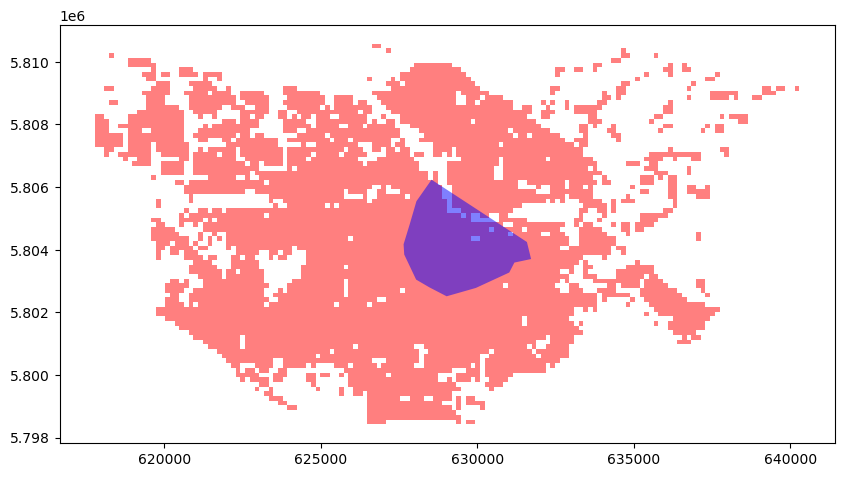

In [122]:
# 绘制building_grid和边框city_center_boundary_box
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
building_grid.plot(ax=ax, color='red', alpha=0.5)
city_center_boundary_box.plot(ax=ax, color='blue', alpha=0.5)
plt.show()

In [123]:
# 选取市中心的建筑
df_within = gpd.sjoin(building_grid, city_center_boundary_box, how='inner', predicate='within')

df_not_within = building_grid[~building_grid.index.isin(df_within.index)]

print(len(df_within), len(df_not_within))

338 4955


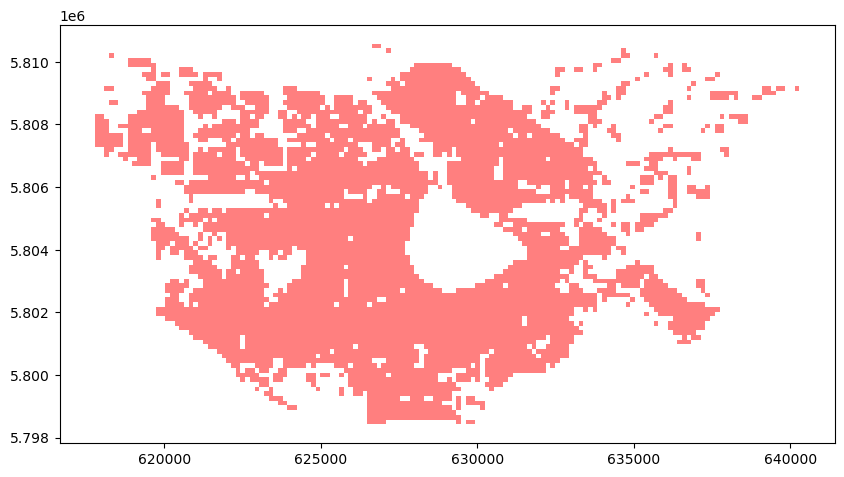

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
df_not_within.plot(ax=ax, color='red', alpha=0.5)
plt.show()

<Axes: >

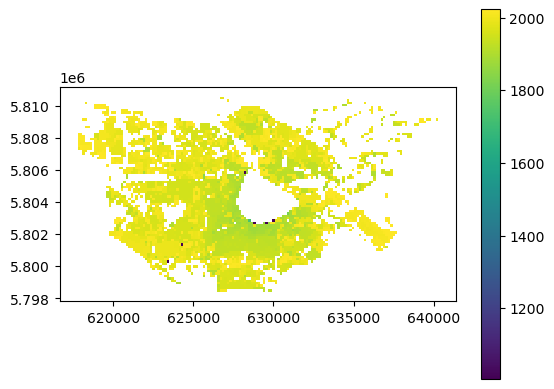

In [125]:
df_not_within.plot(column='bouwjaar', legend=True)

In [126]:
df_not_within.to_file('../../data/output/accuracy_polygon_150m.geojson', driver='GeoJSON')

## 计算郊区的范围的莫兰指数

In [127]:
## 安装和导入库
# conda install pysal
import pysal as ps
import geopandas as gpd
import numpy as np

,id_left,bouwjaar,geometry
0,58,1939.0,"POLYGON ((626484.839 5798425.740, 626484.839 5..."
1,59,2010.0,"POLYGON ((626784.839 5798425.740, 626634.839 5..."
2,60,2006.0,"POLYGON ((626934.839 5798575.740, 626934.839 5..."
3,61,2006.0,"POLYGON ((626934.839 5798425.740, 626934.839 5..."
4,77,1928.0,"POLYGON ((629334.839 5798575.740, 629484.839 5..."


In [128]:
# 创建一个空间权重矩阵对象
# 例如，使用Queen的连通性标准
w = ps.lib.weights.Queen.from_dataframe(df_not_within)


C:\Users\hncdj\anaconda3\envs\dl\Lib\site-packages\pysal\lib\weights\_contW_lists.py:20: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == 'polygon':
C:\Users\hncdj\anaconda3\envs\dl\Lib\site-packages\pysal\lib\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == 'linestring':
C:\Users\hncdj\anaconda3\envs\dl\Lib\site-packages\pysal\lib\weights\weights.py:167: UserWarning: There are 14 disconnected observations 
  Island ids: 1069, 1260, 2650, 3165, 3261, 4413, 4697, 4813, 4847, 4864, 4895, 4947, 4950, 4951
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [129]:
# 标准化权重
w.transform = 'r'

('WARNING: ', 1069, ' is an island (no neighbors)')
('WARNING: ', 1260, ' is an island (no neighbors)')
('WARNING: ', 2650, ' is an island (no neighbors)')
('WARNING: ', 3165, ' is an island (no neighbors)')
('WARNING: ', 3261, ' is an island (no neighbors)')
('WARNING: ', 4413, ' is an island (no neighbors)')
('WARNING: ', 4697, ' is an island (no neighbors)')
('WARNING: ', 4813, ' is an island (no neighbors)')
('WARNING: ', 4847, ' is an island (no neighbors)')
('WARNING: ', 4864, ' is an island (no neighbors)')
('WARNING: ', 4895, ' is an island (no neighbors)')
('WARNING: ', 4947, ' is an island (no neighbors)')
('WARNING: ', 4950, ' is an island (no neighbors)')
('WARNING: ', 4951, ' is an island (no neighbors)')


In [130]:
# 您感兴趣的观测值列
y = df_not_within['bouwjaar'].values

# 计算Moran's I
moran = ps.explore.esda.Moran(y, w)

# 输出Moran's I的值和其他相关统计信息
print("Moran's I: ", moran.I)
print("Expected Moran's I: ", moran.EI)
print("p-value: ", moran.p_sim)

Moran's I:  0.3672452417312258
Expected Moran's I:  -0.00020185708518368994
p-value:  0.001


- 莫兰指数 (Moran's I): 您的数据显示为 0.3672（通常我们只取到小数点后四位）。这是一个正值，表明您的数据集中存在正的空间自相关。简单来说，具有相似特征的观测值在空间上彼此靠近。莫兰指数的值范围从 -1（完全分散）到 +1（完全集聚），而0表示随机分布。您的值接近0.37，表明相对中等程度的正向空间自相关。

- 期望的莫兰指数 (Expected Moran's I): 这个值是 -0.0002，几乎是0，它是在随机情况下可以预期的莫兰指数。理论上，如果观测值是完全随机分布的（即没有空间自相关），莫兰指数应接近于此值。

- p 值: 您的 p 值是 0.001，这是一个非常小的数值，表明您的结果是统计显著的。在统计学中，p 值通常用于判断假设检验的结果是否具有统计意义。一般来说，p 值小于 0.05（有时小于 0.01）被认为是统计显著的，意味着观测到的模式（在这种情况下是空间自相关）很可能不是偶然发生的。

当然，我们知道论文中的郊区的建筑年代的预测的莫兰指数是0.27，我们是建筑真实年代的莫兰指数，注意差别。